In [6]:
import sys
sys.path.insert(0, '/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages')
import disentangler as dt
from disentangler.dependencies import *
import disentangler.frankencell.config as dtconfig
import seaborn as sns

## Write data subsets

In [5]:
rna_data = dt.bonemarrow.utils.load_GEX_data()

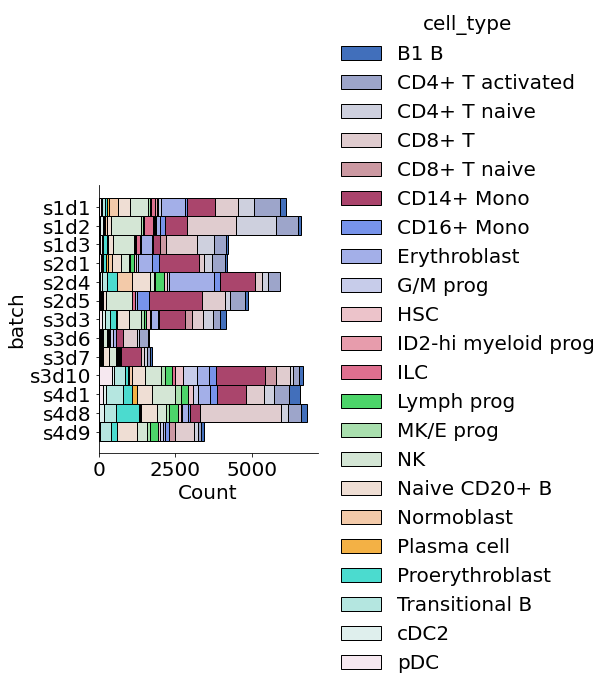

In [6]:
sns.displot(
    data = rna_data.obs,
    y = 'batch',
    hue = 'cell_type',
    multiple = 'stack',
    palette=list(dt.bonemarrow.colors.CELL_PALETTE.values()),
    hue_order=list(dt.bonemarrow.colors.CELL_PALETTE.keys()),
)

In [7]:
!mkdir -p $dtconfig.DATA_DIR

In [8]:
rna_data[rna_data.obs.batch == 's3d10'].write_h5ad(dt.frankencell.config.DATASET_1)
rna_data[rna_data.obs.batch == 's4d1'].write_h5ad(dt.frankencell.config.DATASET_1)

In [9]:
del rna_data

## Generate test

In [12]:
!./dt-cmd frankencell-gen-test \
    ../BatcheffectFrankencell/data/datasets/s3d10_gex.h5ad \
    ../BatcheffectFrankencell/data/datasets/s4d1_gex.h5ad \
    $dtconfig.DATA_DIR/'test0.h5' \
    -k 0.1 \
    -s 0

Stitching cells: 100%|██████████████████████| 2000/2000 [02:51<00:00, 11.66it/s]
/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:62: UserWarning: Error while trying to convert the column "from". Fall back to string conversion. The error is: <class 'numpy.str_'>
  % (name, str(e)))
/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:62: UserWarning: Error while trying to convert the column "to". Fall back to string conversion. The error is: <class 'numpy.str_'>
  % (name, str(e)))
/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:304: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_337793_4877d602632b43f0b3fd8492920a57a3_aa6e7c45e5504bd1a4de7bb0e8f3f9a7/337793-46915876023504-ebc7eddd5fa04ca7b632d17d9a8bdfed.pkl: FileNotFoundError(2, 'No such file or directory')
  'resource_tracker: %s: %r' % (name, e))


import mira
assert mira.__file__ == '/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/__init__.py'

from scipy import sparse
import shutil
import frankencell as fc
import scanpy as sc
from disentangler.frankencell.dimred_methods.utils import read_and_process, plot_umaps

data = read_and_process(dtconfig.DATA_DIR + 'test0.h5')

data.layers['sparse_counts'] = sparse.csr_matrix(data.layers['counts'])

model = mira.topics.TopicModel(
    *data.shape,
    feature_type='expression',
    exogenous_key='highly_variable',
    counts_layer='sparse_counts',
    categorical_covariates='batch',
    cost_beta = 2.
)

model.get_learning_rate_bounds(data)

model.set_learning_rates(3e-3, 0.25)
#model.plot_learning_rate_bounds(figsize=(5,5))

t = mira.topics.Tracker()
model.set_params(num_topics = 6, decoder_dropout = 0.05, 
                 seed = 2556 + 22).fit(data, writer = t)

model.predict(data)

model.get_umap_features(data, box_cox=0.25)
sc.pp.neighbors(data, use_rep='X_umap_features', metric='manhattan')
sc.tl.umap(data, min_dist=0.1)

sc.pl.umap(data, color = ['mix_weight_' + str(i) for i in range(5)] + ['pseudotime', 'batch'],
          frameon=False)

sc.pl.umap(data, color = model.topic_cols, **mira.pref.topic_umap())

sc.pl.umap(data, color = 'batch', palette = ['cornflowerblue','lightgrey'], s= 50, alpha = 0.5,
          add_outline=True, frameon=False)

In [13]:
!rm -rf mira-BENCHMARKING.db

In [14]:
!./dt-cmd frankencell-mira \
    $dtconfig.DATA_DIR/'test0.h5' \
    $dtconfig.DATA_DIR/'test0_result.h5' \
    $dtconfig.DATA_DIR/'test0_plots.png'

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
Writing dataset to disk: 100%|██████████████████| 13/13 [00:02<00:00,  6.43it/s]
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
Writing dataset to disk: 100%|████████████████████| 4/4 [00:00<00:00,  6.76it/s]
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed

In [15]:
!./lib/frankencell-python/cmd-frankencell eval mira \
    -t $dtconfig.DATA_DIR/'test0_result.h5' \
    -o $dtconfig.DATA_DIR/'test0_eval.h5' \
    -r $dtconfig.DATA_DIR/'test0_eval.tsv' \
    -p "threshold=1." \

Executing 'mira' on '20220827_175315__data_wrapper__eteF79uP2c'
With parameters: list(threshold = 1, n_neighbors = 30L, metric = "manhattan",     box_cox = 0.5, ka = 5L)
inputs: counts
priors : start_id, end_id, dimred
Input saved to /tmp/RtmpGLGakM/file54662182507fe/ti
Running ./run --dataset input.h5 --output output.h5
INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 8 components.
INFO:root:Added key to uns: eigen_gap
INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.
Recommending 7 diffusion map components.
lating pseudotime: 2032it [00:00, 252850.32it/s]                     
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added

In [16]:
!cat $dtconfig.DATA_DIR/'test0_eval.tsv'

time_waypointedgeodesic	6.05466294288635
correlation	0.931548432969976
time_correlation	0.732783079147339
edge_flip	1
time_edge_flip	0.0489404201507568
time_mapping_branches	1.35293579101562
recovery_branches	0.691039486306633
relevance_branches	0.691039486306633
F1_branches	0.691039486306633


In [18]:
!./dt-cmd frankencell-gen-test ../BatcheffectFrankencell/data/datasets/s3d10_gex.h5ad ../BatcheffectFrankencell/data/datasets/s4d1_gex.h5ad data/frankencell/test/0.5-0.5-0.0-2556.h5 -k 0.0 -B 0.5 -NK 0.5 --seed 2556 -t 5

Stitching cells: 100%|██████████████████████| 2000/2000 [02:58<00:00, 11.17it/s]
/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:62: UserWarning: Error while trying to convert the column "from". Fall back to string conversion. The error is: <class 'numpy.str_'>
  % (name, str(e)))
/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:62: UserWarning: Error while trying to convert the column "to". Fall back to string conversion. The error is: <class 'numpy.str_'>
  % (name, str(e)))
/liulab/alynch/projects/benchmarking_python/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:304: UserWarning: resource_tracker: /dev/shm/joblib_memmapping_folder_346379_129e53faf9184661bf42d35ab22adc58_633556d11bf94ff8b8ed27e8031fb29c/346379-46915873979664-ed0b093f71cd47278d276fd40649b3d5.pkl: FileNotFoundError(2, 'No such file or directory')
  'resource_tracker: %s: %r' % (name, e))


In [26]:
!mkdir -p data/frankencell/process/mira/
!mkdir -p data/frankencell/plots/mira/

In [27]:
!./dt-cmd frankencell-mira data/frankencell/test/0.5-0.5-0.0-2556.h5 data/frankencell/process/mira/0.5-0.5-0.0-2556.h5 data/frankencell/plots/mira/0.5-0.5-0.0-2556.png -t 5

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
Writing dataset to disk: 100%|██████████████████| 13/13 [00:01<00:00,  6.64it/s]
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
Writing dataset to disk: 100%|████████████████████| 4/4 [00:00<00:00,  7.55it/s]
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed.
Trial completed

In [29]:
!mkdir -p data/frankencell/results_summary/mira/
!mkdir -p data/frankencell/results/mira/

In [30]:
!./lib/frankencell-python/cmd-frankencell eval mira -t data/frankencell/process/mira/0.5-0.5-0.0-2556.h5 -o data/frankencell/results/mira/0.5-0.5-0.0-2556.h5 -r data/frankencell/results_summary/mira/0.5-0.5-0.0-2556.tsv -p "threshold=1."

Executing 'mira' on '20220827_182419__data_wrapper__rQclOPYPl1'
With parameters: list(threshold = 1, n_neighbors = 30L, metric = "manhattan",     box_cox = 0.5, ka = 5L)
inputs: counts
priors : start_id, end_id, dimred
Input saved to /tmp/RtmpsPHVQE/file599fe672400aa/ti
Running ./run --dataset input.h5 --output output.h5
INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 8 components.
INFO:root:Added key to uns: eigen_gap
INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.
Recommending 5 diffusion map components.
lating pseudotime: 2157it [00:00, 310673.18it/s]                   
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added k

In [31]:
!snakemake -s disentangler/frankencell/pipeline.smk -np --cores 5

Building DAG of jobs...
Job stats:
job           count    min threads    max threads
----------  -------  -------------  -------------
all               1              1              1
evaluate         55              1              1
gen_test         27              5              5
get_dimred       55              5              5
total           138              1              5


[Sat Aug 27 20:04:02 2022]
rule gen_test:
    output: data/frankencell/test/0.5-0.16666666666666666-0.1-2556.h5
    jobid: 21
    wildcards: NK=0.5, B=0.16666666666666666, K=0.1, seed=2556
    threads: 5
    resources: tmpdir=/tmp

./dt-cmd frankencell-gen-test ../BatcheffectFrankencell/data/datasets/s3d10_gex.h5ad ../BatcheffectFrankencell/data/datasets/s4d1_gex.h5ad data/frankencell/test/0.5-0.16666666666666666-0.1-2556.h5 -k 0.1 -B 0.16666666666666666 -NK 0.5 --seed 2556 -t 5

[Sat Aug 27 20:04:02 2022]
rule gen_test:
    output: data/frankencell/test/0.05555555555555555-0.0-0.0-2556.h5
    jobid: 63
  